In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

from kan import *
from kan.utils import create_dataset, ex_round

torch.set_default_dtype(torch.float64)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### 1. Data Generation

In [2]:
def generate_sdof_data_newmark(samples=1000, dt=0.01, beta=0.25, gamma=0.5):
    m, c, k = 1.0, 1.5, 200.0  # System parameters: mass, damping coefficient, stiffness
    f = np.random.normal(0, 1, samples)  # External force
    f[:5] = 0  # Set initial 5 forces to zero
    
    # Initial conditions (all initialized to zero)
    x = np.zeros(samples)  # Displacement
    v = np.zeros(samples)  # Velocity
    a = np.zeros(samples)  # Acceleration

    # Initial acceleration
    a[0] = (f[0] - c * v[0] - k * x[0]) / m

    # Newmark-beta method
    for i in range(1, samples):
        # Calculate predicted acceleration
        a_pred = (f[i] - c * (v[i-1] + (1 - gamma) * a[i-1] * dt) - k * (x[i-1] + dt * v[i-1] + 0.5 * (1 - 2 * beta) * a[i-1] * dt ** 2)) / (m + gamma * c * dt + beta * k * dt ** 2)
        
        # Update displacement, velocity, and acceleration
        x[i] = x[i-1] + dt * v[i-1] + 0.5 * (1 - 2 * beta) * a[i-1] * dt ** 2 + beta * a_pred * dt ** 2
        v[i] = v[i-1] + (1 - gamma) * a[i-1] * dt + gamma * a_pred * dt
        a[i] = a_pred

    # Prepare input data
    X = np.stack([v, a, f], axis=1)
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(x.reshape(-1, 1)).flatten()

    # Ensure y starts from zero
    y[0] = 0.0

    # X and y are for training, x, v, a, f are for plotting purposes
    return X, y, x, v, a, f

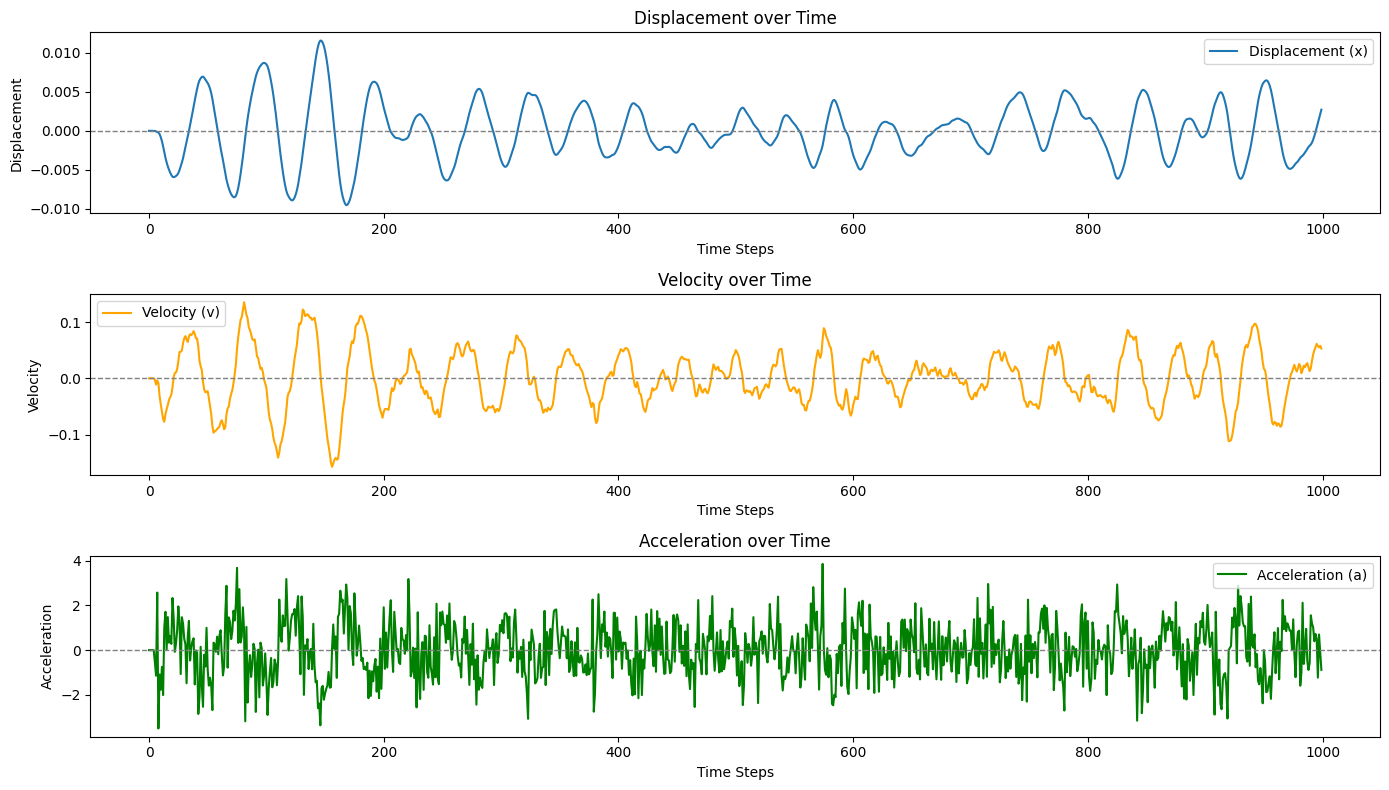

In [3]:
# Generate data and retrieve variables for plotting
X, y, x, v, a, f = generate_sdof_data_newmark()

# Plotting displacement, velocity, and acceleration with a 0 baseline
plt.figure(figsize=(14, 8))

# Displacement plot
plt.subplot(3, 1, 1)
plt.plot(x, label="Displacement (x)")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # 0 기준선
plt.title("Displacement over Time")
plt.xlabel("Time Steps")
plt.ylabel("Displacement")
plt.legend()

# Velocity plot
plt.subplot(3, 1, 2)
plt.plot(v, label="Velocity (v)", color="orange")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # 0 기준선
plt.title("Velocity over Time")
plt.xlabel("Time Steps")
plt.ylabel("Velocity")
plt.legend()

# Acceleration plot
plt.subplot(3, 1, 3)
plt.plot(a, label="Acceleration (a)", color="green")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # 0 기준선
plt.title("Acceleration over Time")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend()

plt.tight_layout()
plt.show()

### 2. KAN Model Initialization

In [4]:
# Create a KAN model: 3D inputs, 1D output, with hidden layers similar in size to CNN and MLP (32, 16 neurons). cubic spline (k=3), 5 grid intervals (grid=5).
kan_model = KAN(width=[3, 5, 1], grid=3, k=3, seed=42, device=device)


checkpoint directory created: ./model
saving model version 0.0


### 3. Data Preparation

In [5]:
# # Create dataset for training
# X, y = generate_sdof_data_newmark()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float64).to(device)
y_tensor = torch.tensor(y, dtype=torch.float64).unsqueeze(1).to(device)


### 4. CNN and MLP Model Definitions

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 250, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1000)  # Match sequence length
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

class MLP(nn.Module):
    def __init__(self, input_features=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)


### 5. Model Initialization

In [7]:
cnn_model = CNN().to(device)
mlp_model = MLP().to(device)

# Initialize weights

def initialize_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

cnn_model.apply(initialize_weights)
mlp_model.apply(initialize_weights)
kan_model.apply(initialize_weights)


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

### 6. Training Function

In [8]:
def train_model(model, X, y, epochs=500, lr=1e-4):
    """Train model and return loss history."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loss_history = []  # Track loss values
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X)
        if isinstance(model, CNN):
            outputs = outputs.view(-1, 1)
        elif outputs.dim() == 1:
            outputs = outputs.unsqueeze(1)
        
        # Check for NaNs in outputs
        if torch.isnan(outputs).any():
            print(f"NaN detected in model outputs at epoch {epoch + 1}")
            outputs = torch.nan_to_num(outputs, nan=0.0)
        
        loss = loss_fn(outputs, y)
        if torch.isnan(loss):
            print(f"NaN detected in loss at epoch {epoch + 1}")
            loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True).to(device)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        loss_history.append(loss.item())  # Store loss value
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    return loss_history


### 7. Training KAN Model

Epoch [100/22000], Loss: 0.1264
Epoch [200/22000], Loss: 0.1252
Epoch [300/22000], Loss: 0.1240
Epoch [400/22000], Loss: 0.1229
Epoch [500/22000], Loss: 0.1220
Epoch [600/22000], Loss: 0.1211
Epoch [700/22000], Loss: 0.1202
Epoch [800/22000], Loss: 0.1195
Epoch [900/22000], Loss: 0.1188
Epoch [1000/22000], Loss: 0.1181
Epoch [1100/22000], Loss: 0.1175
Epoch [1200/22000], Loss: 0.1169
Epoch [1300/22000], Loss: 0.1164
Epoch [1400/22000], Loss: 0.1159
Epoch [1500/22000], Loss: 0.1154
Epoch [1600/22000], Loss: 0.1150
Epoch [1700/22000], Loss: 0.1145
Epoch [1800/22000], Loss: 0.1141
Epoch [1900/22000], Loss: 0.1137
Epoch [2000/22000], Loss: 0.1133
Epoch [2100/22000], Loss: 0.1129
Epoch [2200/22000], Loss: 0.1125
Epoch [2300/22000], Loss: 0.1121
Epoch [2400/22000], Loss: 0.1117
Epoch [2500/22000], Loss: 0.1113
Epoch [2600/22000], Loss: 0.1110
Epoch [2700/22000], Loss: 0.1106
Epoch [2800/22000], Loss: 0.1102
Epoch [2900/22000], Loss: 0.1098
Epoch [3000/22000], Loss: 0.1094
Epoch [3100/22000],

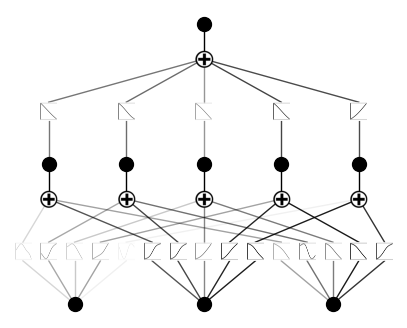

In [9]:
# Train the model with Adam optimizer for KAN model
loss_histories = defaultdict(list)
loss_histories['KAN'] = train_model(kan_model, X_tensor, y_tensor, epochs=22000, lr=1e-5)  # Reduced learning rate for stability

# Plot the model at initialization
kan_model.plot()  # Removed redundant plot


### 8. Pruning and Refinement

saving model version 0.1
Epoch [100/500], Loss: 0.0262
Epoch [200/500], Loss: 0.0218
Epoch [300/500], Loss: 0.0180
Epoch [400/500], Loss: 0.0149
Epoch [500/500], Loss: 0.0123


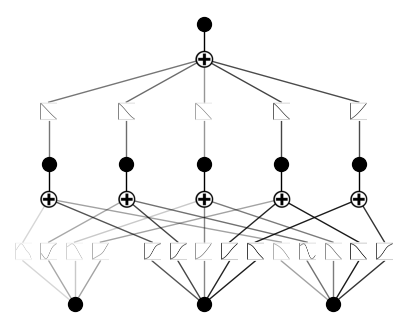

In [10]:
# Prune the model to simplify the structure
kan_model = kan_model.prune()

# Plot pruned model
kan_model.plot()

# Continue training after pruning
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=500, lr=1e-5)


### 9. Further Refinement

In [11]:
# Refine the model by splitting nodes
kan_model = kan_model.refine(10)

# Train the model again
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=500, lr=1e-5)


saving model version 0.2
Epoch [100/500], Loss: 0.0095
Epoch [200/500], Loss: 0.0074
Epoch [300/500], Loss: 0.0059
Epoch [400/500], Loss: 0.0048
Epoch [500/500], Loss: 0.0040


### 10. Set Activation Functions to Symbolic

In [12]:
# Retrain KAN to stabilize before symbolic assignment
print("Retraining KAN model to stabilize before symbolic assignment...")
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=500, lr=1e-6)  # Further reduced learning rate for stability

# Clamp model outputs to avoid NaN values
with torch.no_grad():
    output_check = kan_model(X_tensor)
    output_check = torch.clamp(output_check, min=-10, max=10)  # Clamp output values to prevent NaNs

mode = "auto"  # "manual" or "auto"

if mode == "manual":
    # Manually set symbolic functions
    kan_model.fix_symbolic(0, 0, 0, 'sin')
    kan_model.fix_symbolic(0, 1, 0, 'x^2')
    kan_model.fix_symbolic(1, 0, 0, 'exp')
elif mode == "auto":
    # Automatically find symbolic functions
    # lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
    lib = ['x']
    kan_model.auto_symbolic(lib=lib)

# Train till convergence with a reduced learning rate for stability
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=500, lr=1e-6)


Retraining KAN model to stabilize before symbolic assignment...
Epoch [100/500], Loss: 0.0039
Epoch [200/500], Loss: 0.0038
Epoch [300/500], Loss: 0.0037
Epoch [400/500], Loss: 0.0036
Epoch [500/500], Loss: 0.0035
fixing (0,0,0) with x, r2=0.8163573657295673, c=1
fixing (0,0,1) with x, r2=0.8591185698666648, c=1
fixing (0,0,2) with x, r2=0.8445085754082191, c=1
fixing (0,0,3) with x, r2=0.9325475949048742, c=1
fixing (0,0,4) with 0
fixing (0,1,0) with x, r2=0.9798143355993935, c=1
fixing (0,1,1) with x, r2=0.9850680855118567, c=1
fixing (0,1,2) with x, r2=0.9808912444114508, c=1
fixing (0,1,3) with x, r2=0.9963772503743428, c=1
fixing (0,1,4) with x, r2=0.9882350100347297, c=1
fixing (0,2,0) with x, r2=0.9794511705158612, c=1
fixing (0,2,1) with x, r2=0.9391152668446701, c=1
fixing (0,2,2) with x, r2=0.9968748682070141, c=1
fixing (0,2,3) with x, r2=0.9921022290785739, c=1
fixing (0,2,4) with x, r2=0.9876240415507969, c=1
fixing (1,0,0) with x, r2=0.999755659812426, c=1
fixing (1,1,0) 

### 11. Obtain the Symbolic Formula

Symbolic Expression: -0.098*x_1 - 1.604*x_2 + 1.556*x_3 - 0.164


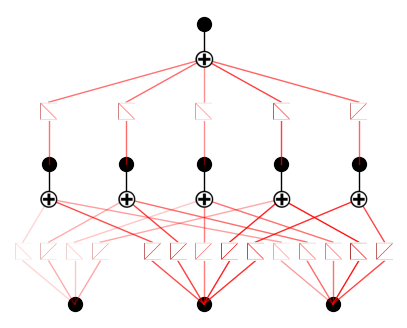

In [13]:
symbolic_expression = ex_round(kan_model.symbolic_formula()[0][0], 3)
print(f"Symbolic Expression: {symbolic_expression}")

# Plot the final model
kan_model.plot()


Layer 0, Node 0: -0.094*x_1 + 0.4986*x_2 - 0.27*x_3 + 0.21
Layer 0, Node 1: 0.1808*x_1 + 0.5375*x_2 - 0.4166*x_3 - 0.0183
Layer 0, Node 2: -0.153*x_1 + 0.3896*x_2 - 0.5034*x_3 - 0.0107
Layer 0, Node 3: 0.1415*x_1 + 0.5471*x_2 - 0.7108*x_3 + 0.0643
Layer 0, Node 4: -0.6277*x_2 + 0.5677*x_3 + 0.1421
Layer 0, After scaling Node 4: -0.6277*x_2 + 0.5677*x_3 + 0.1421
Layer 1, Node 0: -0.098*x_1 - 1.6044*x_2 + 1.5555*x_3 - 0.1636
Layer 1, After scaling Node 0: -0.098*x_1 - 1.6044*x_2 + 1.5555*x_3 - 0.1636
Symbolic Expression: -0.098*x_1 - 1.604*x_2 + 1.556*x_3 - 0.164


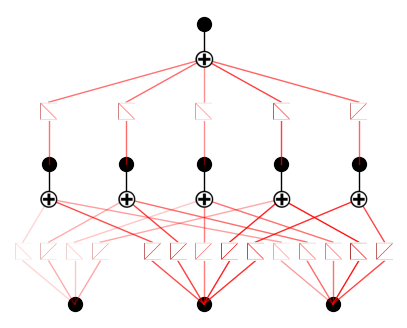

In [14]:
# Retrieve symbolic expression with node information
symbolic_expression, _ = kan_model.symbolic_formula(show_nodes=True)

# Round the symbolic expression
symbolic_expression = ex_round(symbolic_expression[0], 3)
print(f"Symbolic Expression: {symbolic_expression}")

# Plot the final model
kan_model.plot()

### 12. Training CNN and MLP Models

In [15]:


# print("\nTraining CNN...")
# loss_histories['CNN'] = train_model(cnn_model, X_tensor.unsqueeze(0).transpose(1, 2), y_tensor)

# print("\nTraining MLP...")
# loss_histories['MLP'] = train_model(mlp_model, X_tensor, y_tensor)


In [16]:
device = torch.device('cpu')

### 13. Plot Training Loss Curves


Plotting loss curves...


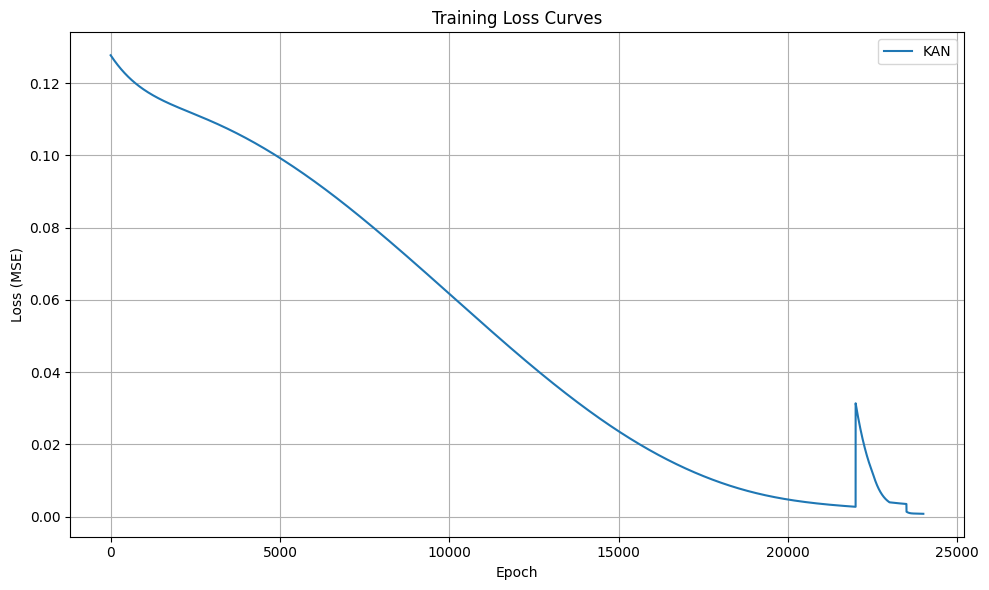

In [17]:
def plot_loss_curves(loss_histories, title="Training Loss Curves"):
    """Plot training loss curves for all models."""
    plt.figure(figsize=(10, 6))
    
    for model_name, loss_history in loss_histories.items():
        plt.plot(loss_history, label=model_name)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPlotting loss curves...")
plot_loss_curves(loss_histories)


### 14. Model Comparison Visualization


Plotting prediction results...


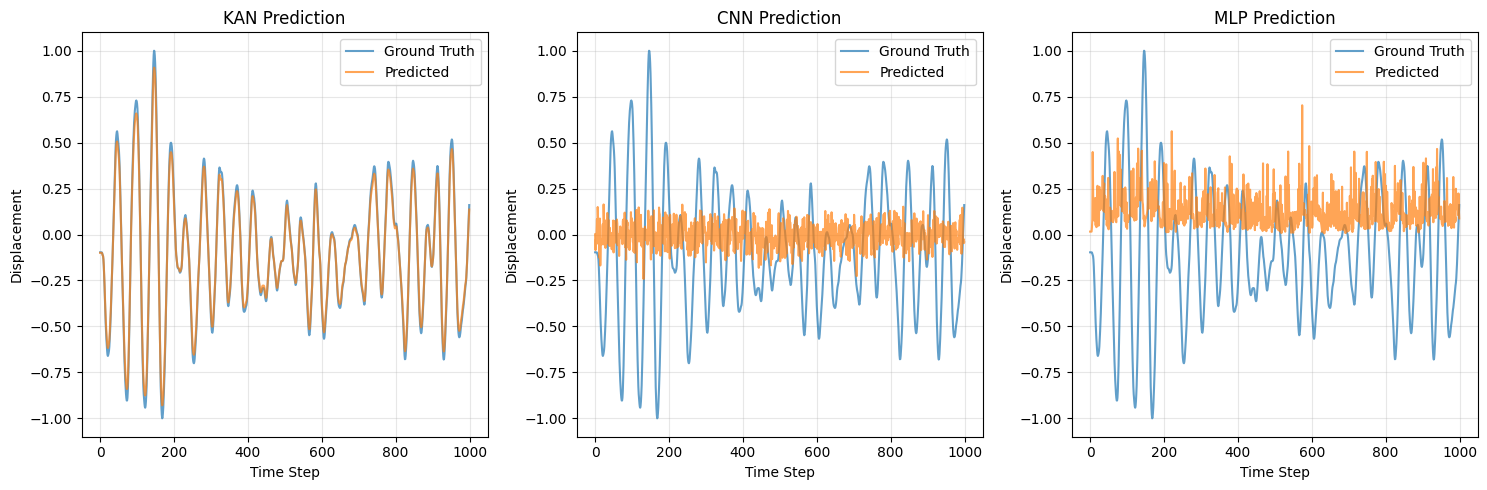

In [22]:
def plot_results(models, X_tensor, X_cnn, y, title_prefix="Model Predictions"):
    """Plot model predictions."""
    plt.figure(figsize=(15, 5))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(1, 3, i)
        model.eval()
        with torch.no_grad():
            if name == 'CNN':
                predictions = model(X_cnn)
                y_pred = predictions.squeeze().cpu().numpy()
            else:  # KAN or MLP
                predictions = model(X_tensor)
                y_pred = predictions.squeeze().cpu().numpy()
            
            # Ensure y_pred is the right shape
            if y_pred.ndim == 0:
                y_pred = np.array([float(y_pred)])
            
            # Plot only first 200 points
            plot_range = slice(0, 1000)
            plt.plot(y[plot_range], label='Ground Truth', alpha=0.7)
            plt.plot(y_pred[plot_range], label='Predicted', alpha=0.7)
            plt.title(f'{name} Prediction')
            plt.xlabel('Time Step')
            plt.ylabel('Displacement')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

models = {
    'KAN': kan_model,
    'CNN': cnn_model,
    'MLP': mlp_model
}

print("\nPlotting prediction results...")
plot_results(models, X_tensor, X_tensor.unsqueeze(0).transpose(1, 2), y)


In [19]:
# Extract model predictions for KAN, CNN, and MLP
models['KAN'].eval()
# models['MLP'].eval()
# models['CNN'].eval()

with torch.no_grad():
    kan_predictions = models['KAN'](X_tensor).cpu().numpy()
    # mlp_predictions = models['MLP'](X_tensor).cpu().numpy()
    # cnn_predictions = models['CNN'](X_tensor.unsqueeze(0).transpose(1, 2)).cpu().numpy().squeeze()

# Create a DataFrame for the first 200 time steps
data = {
    'Time Step': np.arange(200),
    'Ground Truth': y[:200],
    'KAN Prediction': kan_predictions[:200].flatten(),
    # 'MLP Prediction': mlp_predictions[:200].flatten(),
    # 'CNN Prediction': cnn_predictions[:200].flatten()
}

predictions_df = pd.DataFrame(data)

# Save the DataFrame as a CSV file
csv_filename = "/home/user/WindowsShare/06. Programming/develop/JM_KAN/model_predictions.csv"
predictions_df.to_csv(csv_filename, index=False)

print(f"Predictions saved as {csv_filename}")

# # Optionally display DataFrame to user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Predictions vs Ground Truth (First 200 Time Steps)", dataframe=predictions_df)

Predictions saved as /home/user/WindowsShare/06. Programming/develop/JM_KAN/model_predictions.csv



Plotting prediction results...
First 10 values of y (Ground Truth): [-0.09684669 -0.09684669 -0.09684669 -0.09684669 -0.09684669 -0.09813562
 -0.1047107  -0.11187751 -0.11784031 -0.13690567]


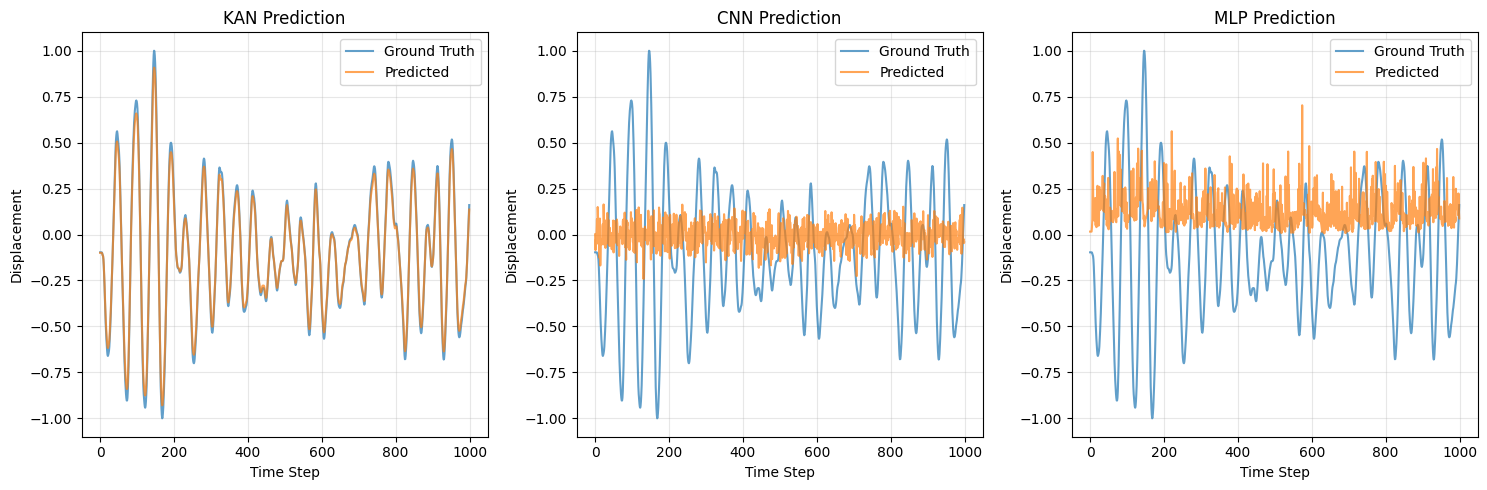

In [25]:
def plot_results(models, X_tensor, X_cnn, y, title_prefix="Model Predictions"):
    """Plot model predictions."""
    plt.figure(figsize=(15, 5))
    
    # Ensure y starts around 0 by checking its values
    print("First 10 values of y (Ground Truth):", y[:10])  # Check y values

    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(1, 3, i)
        model.eval()
        with torch.no_grad():
            if name == 'CNN':
                predictions = model(X_cnn)
                y_pred = predictions.squeeze().cpu().numpy()
            else:  # KAN or MLP
                predictions = model(X_tensor)
                y_pred = predictions.squeeze().cpu().numpy()
            
            # Ensure y_pred is the right shape
            if y_pred.ndim == 0:
                y_pred = np.array([float(y_pred)])
            
            # Adjust plot range to match y if needed
            plot_range = slice(0, min(len(y), 1000))  # Make sure plot range matches y length
            
            # Plot ground truth and predictions
            plt.plot(y[plot_range], label='Ground Truth', alpha=0.7)
            plt.plot(y_pred[plot_range], label='Predicted', alpha=0.7)
            plt.title(f'{name} Prediction')
            plt.xlabel('Time Step')
            plt.ylabel('Displacement')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\nPlotting prediction results...")
plot_results(models, X_tensor, X_tensor.unsqueeze(0).transpose(1, 2), y)

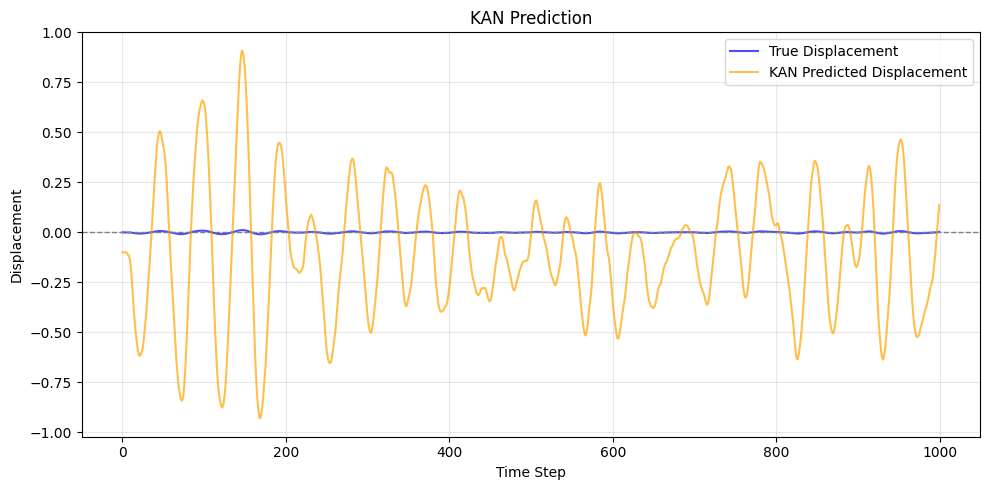

In [30]:
def plot_kan_results(kan_model, X_tensor, y, x, title="KAN Prediction"):
    """Plot KAN model predictions against true displacement."""
    plt.figure(figsize=(10, 5))
    
    kan_model.eval()
    with torch.no_grad():
        # Get KAN model predictions
        predictions = kan_model(X_tensor)
        y_pred = predictions.squeeze().cpu().numpy()
        
        # Plot ground truth (true displacement) and predictions
        plot_range = slice(0, min(len(y), 1000))  # Adjust plot range
        plt.plot(x[plot_range], label="True Displacement", color="blue", alpha=0.7)
        plt.plot(y_pred[plot_range], label="KAN Predicted Displacement", color="orange", alpha=0.7)
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # 0 기준선
        plt.title(title)
        plt.xlabel("Time Step")
        plt.ylabel("Displacement")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_kan_results(kan_model, X_tensor, y, x)

In [40]:
def plot_kan_results_with_range_check(kan_model, X_tensor, y, original_displacement, scaler_y, device, title="KAN Model Prediction"):
    """
    Plot KAN model predictions with detailed range checking
    """
    plt.figure(figsize=(10, 6))
    
    # Print original data range
    print("Data Ranges:")
    print(f"Original displacement range: [{np.min(original_displacement):.6f}, {np.max(original_displacement):.6f}]")
    
    kan_model.eval()
    with torch.no_grad():
        # Get predictions
        predictions = kan_model(X_tensor)
        y_pred = predictions.cpu().squeeze().numpy()
        
        # Print normalized prediction range
        print(f"Normalized prediction range: [{np.min(y_pred):.6f}, {np.max(y_pred):.6f}]")
        
        # Ensure predictions are in the correct shape for inverse transform
        y_pred_reshaped = y_pred.reshape(-1, 1)
        y_pred_original = scaler_y.inverse_transform(y_pred_reshaped).flatten()
        
        # Print inverse transformed range
        print(f"Inverse transformed prediction range: [{np.min(y_pred_original):.6f}, {np.max(y_pred_original):.6f}]")
        
        # Plot results
        plot_range = slice(0, 1000)
        plt.plot(original_displacement[plot_range], label="Ground Truth", color="blue", alpha=0.7)
        plt.plot(y_pred_original[plot_range], label="KAN Predicted", color="orange", alpha=0.7)
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
        plt.title(title)
        plt.xlabel("Time Step")
        plt.ylabel("Displacement")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print first few values
    print("\nFirst 5 values comparison:")
    print("Original:", original_displacement[:5])
    print("Predicted (after inverse):", y_pred_original[:5])
    
    # Print scaling parameters
    print("\nScaler parameters:")
    print("Data min:", scaler_y.data_min_)
    print("Data max:", scaler_y.data_max_)
    print("Scale:", scaler_y.scale_)
    print("Min:", scaler_y.min_)

# 데이터 생성 시 스케일러 파라미터 출력하도록 수정
def generate_sdof_data_newmark_with_detailed_scaling(samples=1000, dt=0.01, beta=0.25, gamma=0.5):
    """Generate SDOF data with detailed scaling information"""
    m, c, k = 1.0, 1.5, 200.0
    f = np.random.normal(0, 1, samples)
    f[:5] = 0
    
    x = np.zeros(samples)
    v = np.zeros(samples)
    a = np.zeros(samples)
    a[0] = (f[0] - c * v[0] - k * x[0]) / m
    
    for i in range(1, samples):
        a_pred = (f[i] - c * (v[i-1] + (1 - gamma) * a[i-1] * dt) - 
                 k * (x[i-1] + dt * v[i-1] + 0.5 * (1 - 2 * beta) * a[i-1] * dt ** 2)) / (
                 m + gamma * c * dt + beta * k * dt ** 2)
        
        x[i] = x[i-1] + dt * v[i-1] + 0.5 * (1 - 2 * beta) * a[i-1] * dt ** 2 + beta * a_pred * dt ** 2
        v[i] = v[i-1] + (1 - gamma) * a[i-1] * dt + gamma * a_pred * dt
        a[i] = a_pred
    
    print("\nOriginal data statistics:")
    print(f"Displacement range: [{np.min(x):.6f}, {np.max(x):.6f}]")
    
    X = np.stack([v, a, f], axis=1)
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(x.reshape(-1, 1)).flatten()
    
    print("\nNormalized displacement range:")
    print(f"[{np.min(y_normalized):.6f}, {np.max(y_normalized):.6f}]")
    
    return X_normalized, y_normalized, x, v, a, f, scaler_y


Original data statistics:
Displacement range: [-0.011468, 0.011007]

Normalized displacement range:
[-1.000000, 1.000000]
Data Ranges:
Original displacement range: [-0.011468, 0.011007]
Normalized prediction range: [-1.025715, 0.882671]
Inverse transformed prediction range: [-0.011757, 0.009688]


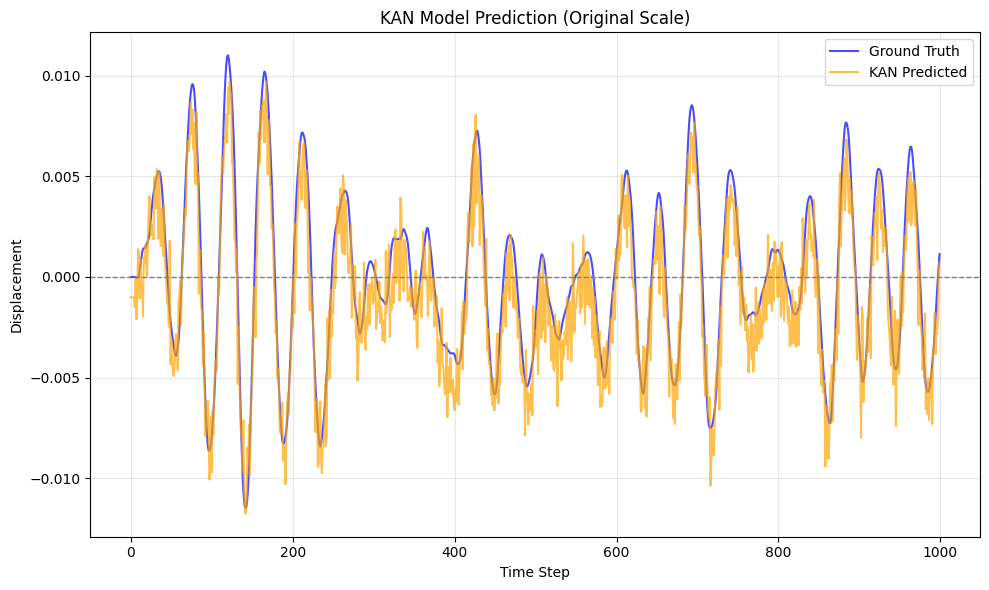


First 5 values comparison:
Original: [0. 0. 0. 0. 0.]
Predicted (after inverse): [-0.00100695 -0.00100695 -0.00100695 -0.00100695 -0.00100695]

Scaler parameters:
Data min: [-0.01146814]
Data max: [0.01100676]
Scale: [88.98818685]
Min: [0.0205286]


In [41]:
# Generate new data with detailed scaling information
X, y, x, v, a, f, scaler_y = generate_sdof_data_newmark_with_detailed_scaling()
X_tensor = torch.tensor(X, dtype=torch.float64).to(device)
y_tensor = torch.tensor(y, dtype=torch.float64).unsqueeze(1).to(device)

# Plot results with range checking
plot_kan_results_with_range_check(kan_model, X_tensor, y, x, scaler_y, device, "KAN Model Prediction (Original Scale)")


Original data statistics:
Displacement range: [-0.008896, 0.010362]
Velocity range: [-0.143896, 0.144039]
Acceleration range: [-4.275409, 3.595742]
Data ranges at each step:
Original displacement: [-0.008896, 0.010362]
Normalized predictions: [-1.099683, 0.798605]
MinMaxScaler inverse range: [-0.009855, 0.008423]
Manual scaling range: [-0.009855, 0.008423]
Amplitude matching range: [-0.010362, 0.007525]


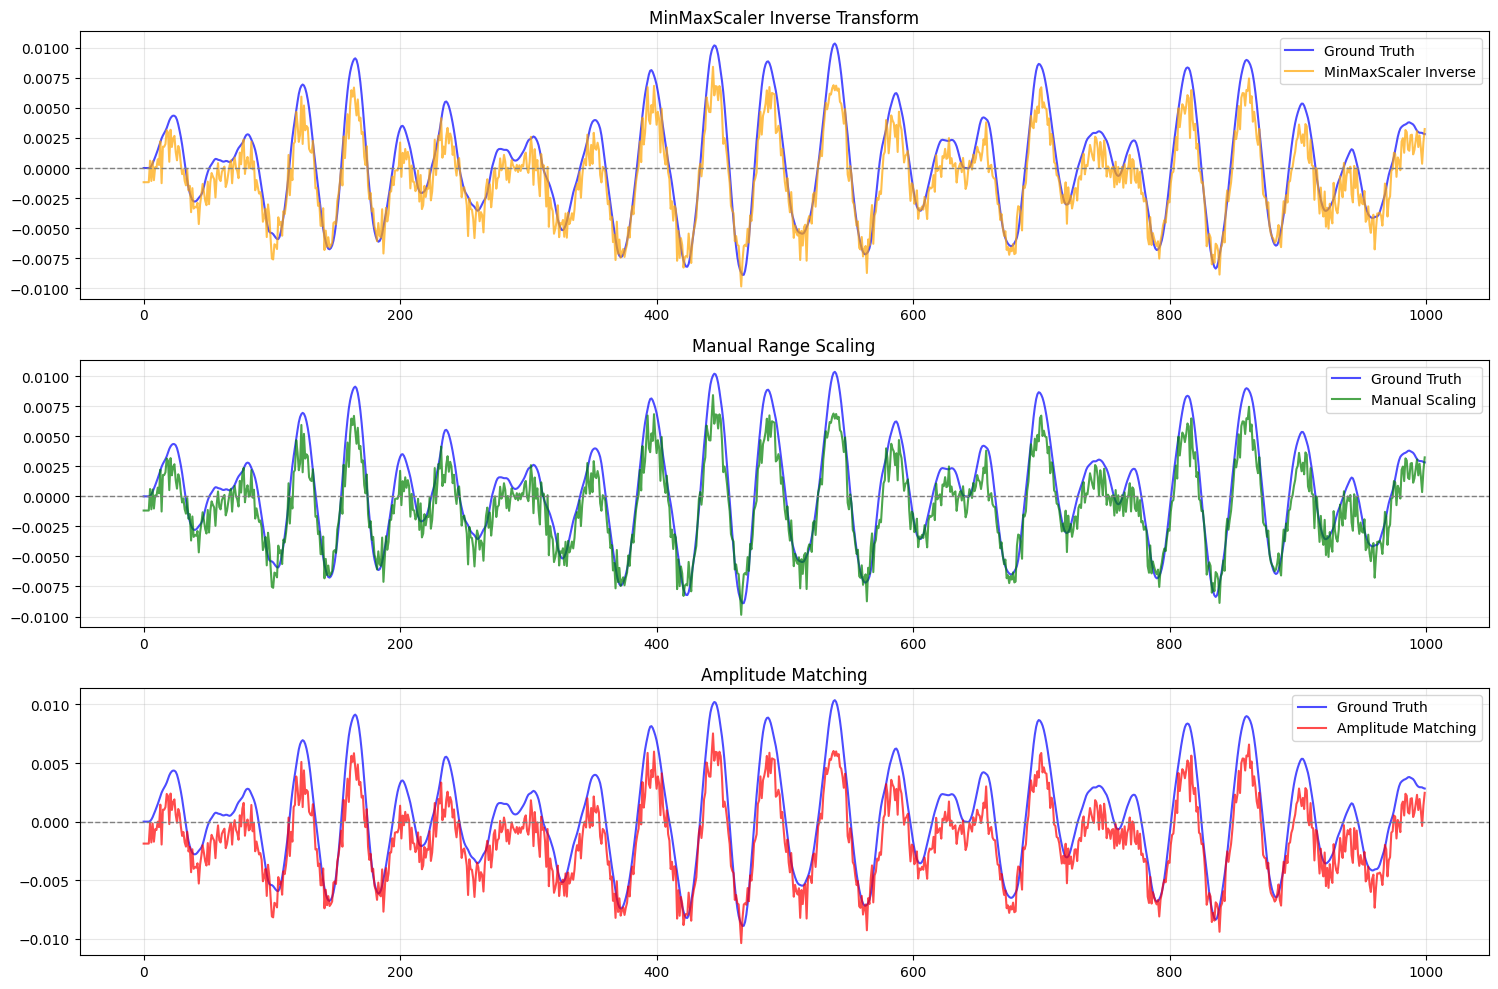

In [49]:
def plot_results(model, X_tensor, y, title="KAN Model Prediction"):
    """Plot KAN model predictions with zero start."""
    plt.figure(figsize=(10, 6))
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor)
        y_pred = predictions.squeeze().cpu().numpy()
        
        # Calculate constants to make both start at 0
        y_constant = y[0]
        y_pred_constant = y_pred[0]
        
        # Adjust values to start from 0
        y_adjusted = y - y_constant
        y_pred_adjusted = y_pred - y_pred_constant
        
        # Plot
        plot_range = slice(0, min(len(y), 1000))
        plt.plot(y_adjusted[plot_range], label='Ground Truth', alpha=0.7)
        plt.plot(y_pred_adjusted[plot_range], label='Predicted', alpha=0.7)
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
        plt.title(title)
        plt.xlabel('Time Step')
        plt.ylabel('Displacement')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Plotting KAN prediction results...


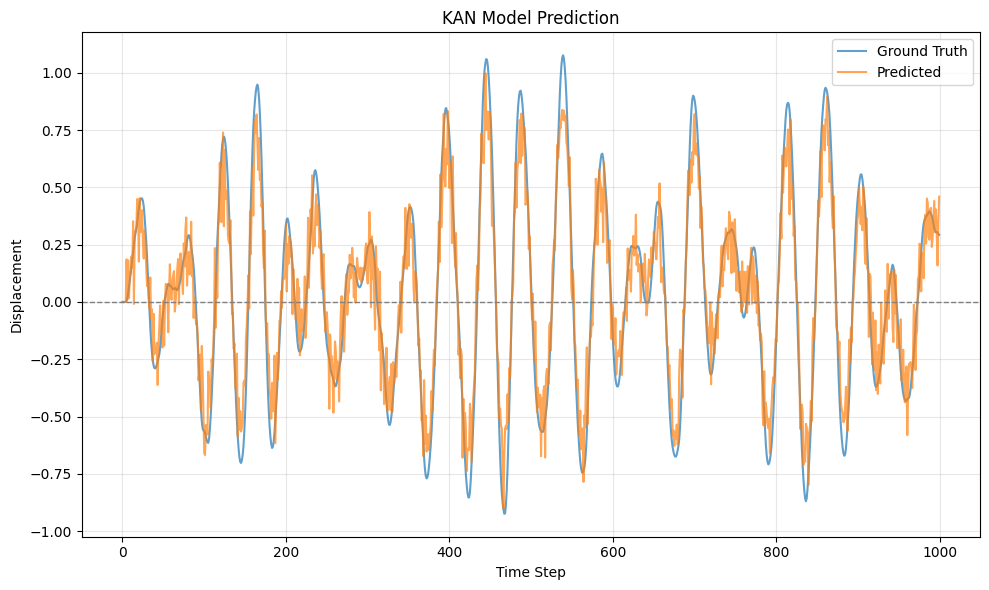

In [50]:
print("\nPlotting KAN prediction results...")
plot_results(kan_model, X_tensor, y)